# Predicting Kickstarter Success

### Steps
1. Explore and clean data
2. Feature engineer "campaign_length"
3. Normalize data
4. Use these features in a Feed-Forward Neural Net first:
    - Goal (make sure to convert all non-US currencies to US) (number)
    - Category (dropdown → string)
    - Main category (dropdown → string)
    - Campaign length (in days)
- We are predicting "Pledged Amount"
5. Document score
6. Add in "name", tokenize and vectorize, pad_sequence up to MAXLEN
7. Run Neural Net, docuemnt score
8. Build LSTM, run and document score
9. Choose which model to train hyperparameters on
10. Make param_grid and set up GridSearchCV
11. Git push, tell Jonathan it's ready for training
12. Pickle and save model, help data engineering team

In [1]:
# Import libraries
import os
import re
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from xgboost import XGBRegressor
import xgboost
# import shap
# import graphviz

# shap.initJs()
pd.set_option("display.max_columns", False)
nlp = spacy.load('en_core_web_md')

/Users/WonderWolff/.local/share/virtualenvs/Kickstarter_Success_Predictor-jaK0ryJK/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Import dataset
data_url_2 = '../csvs/kickstarter_data_with_features.csv'
df = pd.read_csv(data_url_2)

df = df[(df['state'] != 'live') & (df['state'] != 'suspended')]

df.head()

Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.


,Unnamed: 0,id,photo,name,blurb,goal,pledged,state,slug,disable_communication,country,currency,currency_symbol,currency_trailing_code,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,static_usd_rate,usd_pledged,creator,location,category,profile,spotlight,urls,source_url,friends,is_starred,is_backing,permissions,name_len,name_len_clean,blurb_len,blurb_len_clean,deadline_weekday,state_changed_at_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,deadline_yr,deadline_hr,state_changed_at_month,state_changed_at_day,state_changed_at_yr,state_changed_at_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch,launch_to_deadline,launch_to_state_change
0,0,1454391034,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,0.0,failed,auntie-dis-music-time-sign-asl-for-hearing-and...,False,US,USD,$,True,2015-01-23 10:35:00,2015-01-23 10:35:00,2014-11-29 22:55:57,2014-12-17 13:47:36,False,0,1.000000,0.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",Academic,"{""background_image_opacity"":0.8,""should_show_f...",False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,11.0,9.0,21.0,16.0,Friday,Friday,Saturday,Wednesday,1,23,2015,10,1,23,2015,10,11,29,2014,22,12,17,2014,13,17 days 14:51:39.000000000,36 days 20:47:24.000000000,NaN
1,1,1655206086,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,0.0,failed,jump-start-kindergarten-toolkit,False,US,USD,$,True,2015-05-01 16:13:22,2015-05-01 16:13:24,2015-02-20 09:28:43,2015-03-02 16:13:22,False,0,1.000000,0.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",Academic,"{""background_image_opacity"":0.8,""should_show_f...",False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,4.0,4.0,23.0,15.0,Friday,Friday,Friday,Monday,5,1,2015,16,5,1,2015,16,2,20,2015,9,3,2,2015,16,10 days 06:44:39.000000000,60 days 00:00:00.000000000,NaN
2,2,311581827,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,120.0,failed,ojukwu-balewa-awolowo-oba-public-library-of-ni...,False,US,USD,$,True,2015-03-26 08:17:04,2015-03-26 08:17:05,2015-01-24 00:08:06,2015-01-25 08:17:04,False,5,1.000000,120.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""NG"",""urls"":{""web"":{""discover"":""htt...",Academic,"{""background_image_opacity"":0.8,""should_show_f...",False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,8.0,8.0,18.0,10.0,Thursday,Thursday,Saturday,Sunday,3,26,2015,8,3,26,2015,8,1,24,2015,0,1,25,2015,8,1 days 08:08:58.000000000,60 days 00:00:00.000000000,NaN
3,3,859724515,"{""small"":""https://ksr-ugc.imgix.net/assets/011...","MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,0.0,failed,mastize-mas-tahyz-mas-tahyz-to-spread,False,US,USD,$,True,2014-10-06 00:41:17,2014-10-06 00:41:17,2014-09-05 22:30:00,2014-09-06 00:41:17,False,0,1.000000,0.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",Academic,"{""background_image_opacity"":0.8,""should_show_f...",False,"{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,7.0,6.0,21.0,13.0,Monday,Monday,Friday,Saturday,10,6,2014,0,10,6,20

In [3]:
df_2 = df[['name','blurb','goal','category','name_len','blurb_len',
       'deadline_weekday','launched_at_weekday','deadline_month',
       'launched_at_month','launch_to_deadline','state','usd_pledged']]

df_2.head()

,name,blurb,goal,category,name_len,blurb_len,deadline_weekday,launched_at_weekday,deadline_month,launched_at_month,launch_to_deadline,state,usd_pledged
0,Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,Academic,11.0,21.0,Friday,Wednesday,1,12,36 days 20:47:24.000000000,failed,0.000000
1,Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,Academic,4.0,23.0,Friday,Monday,5,3,60 days 00:00:00.000000000,failed,0.000000
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,Academic,8.0,18.0,Thursday,Sunday,3,1,60 days 00:00:00.000000000,failed,120.000000
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,Academic,7.0,21.0,Monday,Saturday,10,9,30 days 00:00:00.000000000,failed,0.000000
4,"Synopse der EU-DSGVO - Artikel, Erwägungsgründ...",Zu den Artikeln der DSGVO sind die korrespondi...,3222.0,Academic,7.0,18.0,Monday,Thursday,6,5,32 days 06:02:33.000000000,failed,396.802395


In [4]:
df_2 = df_2.dropna()

In [5]:
df_2.isnull().sum()

name                   0
blurb                  0
goal                   0
category               0
name_len               0
blurb_len              0
deadline_weekday       0
launched_at_weekday    0
deadline_month         0
launched_at_month      0
launch_to_deadline     0
state                  0
usd_pledged            0
dtype: int64

In [6]:
df_2.shape

(18066, 13)

In [7]:
# Two targets, one for regression and one for classification
y_reg = df_2[['usd_pledged']]
y_class = df_2[['state']]

# Create X dataframe
X = df_2[['name','blurb','goal','category','name_len','blurb_len',
       'deadline_weekday','launched_at_weekday','deadline_month',
       'launched_at_month','launch_to_deadline']]

In [8]:
X['blurb'] = X['blurb'].astype(str)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
X_lem = copy.deepcopy(X)

In [10]:
# Function to OneHotEncode categorical data
def encode_and_concat(og_df, feature):
    dummies = pd.get_dummies(og_df[feature])
    for col in dummies.columns:
        dummies = dummies.rename(columns={col:feature + "_" + col.lower()})
    res = pd.concat([og_df, dummies], axis=1)
    res = res.drop(columns=[feature])
    return res

# OneHotEncode our categorical data
X_lem = encode_and_concat(X_lem, 'category')
X_lem = encode_and_concat(X_lem, 'deadline_weekday')
X_lem = encode_and_concat(X_lem, 'launched_at_weekday')
X_lem.head()

,name,blurb,goal,name_len,blurb_len,deadline_month,launched_at_month,launch_to_deadline,category_academic,category_apps,category_blues,category_comedy,category_experimental,category_festivals,category_flight,category_gadgets,category_hardware,category_immersive,category_makerspaces,category_musical,category_places,category_plays,category_restaurants,category_robots,category_shorts,category_software,category_sound,category_spaces,category_thrillers,category_wearables,category_web,category_webseries,deadline_weekday_friday,deadline_weekday_monday,deadline_weekday_saturday,deadline_weekday_sunday,deadline_weekday_thursday,deadline_weekday_tuesday,deadline_weekday_wednesday,launched_at_weekday_friday,launched_at_weekday_monday,launched_at_weekday_saturday,launched_at_weekday_sunday,launched_at_weekday_thursday,launched_at_weekday_tuesday,launched_at_weekday_wednesday
0,Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,11.0,21.0,1,12,36 days 20:47:24.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,4.0,23.0,5,3,60 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,8.0,18.0,3,1,60 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,"MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,7.0,21.0,10,9,30 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,"Synopse der EU-DSGVO - Artikel, Erwägungsgründ...",Zu den Artikeln der DSGVO sind die korrespondi...,3222.0,7.0,18.0,6,5,32 days 06:02:33.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [11]:
# Drop name and blurb columns
X_lem = X_lem.drop(columns=['name','blurb'])
X_lem.head()

,goal,name_len,blurb_len,deadline_month,launched_at_month,launch_to_deadline,category_academic,category_apps,category_blues,category_comedy,category_experimental,category_festivals,category_flight,category_gadgets,category_hardware,category_immersive,category_makerspaces,category_musical,category_places,category_plays,category_restaurants,category_robots,category_shorts,category_software,category_sound,category_spaces,category_thrillers,category_wearables,category_web,category_webseries,deadline_weekday_friday,deadline_weekday_monday,deadline_weekday_saturday,deadline_weekday_sunday,deadline_weekday_thursday,deadline_weekday_tuesday,deadline_weekday_wednesday,launched_at_weekday_friday,launched_at_weekday_monday,launched_at_weekday_saturday,launched_at_weekday_sunday,launched_at_weekday_thursday,launched_at_weekday_tuesday,launched_at_weekday_wednesday
0,1500.0,11.0,21.0,1,12,36 days 20:47:24.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,500.0,4.0,23.0,5,3,60 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,100000.0,8.0,18.0,3,1,60 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,5000.0,7.0,21.0,10,9,30 days 00:00:00.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,3222.0,7.0,18.0,6,5,32 days 06:02:33.000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [12]:
# Get launch_to_deadline day count
def get_day_count(text):
    
    text = text.split("days")
    text = text[0]
    
    return text

X_lem['campaign_length_days'] = X_lem['launch_to_deadline'].apply(get_day_count)

In [13]:
X_lem = X_lem.drop(columns=['launch_to_deadline'])
X_lem.head()

,goal,name_len,blurb_len,deadline_month,launched_at_month,category_academic,category_apps,category_blues,category_comedy,category_experimental,category_festivals,category_flight,category_gadgets,category_hardware,category_immersive,category_makerspaces,category_musical,category_places,category_plays,category_restaurants,category_robots,category_shorts,category_software,category_sound,category_spaces,category_thrillers,category_wearables,category_web,category_webseries,deadline_weekday_friday,deadline_weekday_monday,deadline_weekday_saturday,deadline_weekday_sunday,deadline_weekday_thursday,deadline_weekday_tuesday,deadline_weekday_wednesday,launched_at_weekday_friday,launched_at_weekday_monday,launched_at_weekday_saturday,launched_at_weekday_sunday,launched_at_weekday_thursday,launched_at_weekday_tuesday,launched_at_weekday_wednesday,campaign_length_days
0,1500.0,11.0,21.0,1,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,36
1,500.0,4.0,23.0,5,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,60
2,100000.0,8.0,18.0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,60
3,5000.0,7.0,21.0,10,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,30
4,3222.0,7.0,18.0,6,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,32


In [14]:
# Save dataframe with tokens
X_with_tokens = copy.deepcopy(X_lem)

In [15]:
for col in X_lem.columns:
    X_lem[col] = X_lem[col].astype(float)

In [16]:
# Create function to encode success/failures
def encode_success(text):
    
    if text == 'successful':
        return 1
    else:
        return 0

In [17]:
y_class.value_counts()

state     
failed        10567
successful     5220
canceled       2279
dtype: int64

In [18]:
y_class['success'] = y_class['state'].apply(encode_success)
y_class = y_class['success']
print(y_class.value_counts())
y_class

0    12846
1     5220
Name: success, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        0
1        0
2        0
3        0
4        0
        ..
20627    0
20628    0
20629    0
20630    0
20631    0
Name: success, Length: 18066, dtype: int64

In [19]:
print(y_class.shape)
print(X_lem.shape)

(18066,)
(18066, 44)


### The code below trains the XGBClassifier. But since we already trained it, I (Austin) will comment it out, as now we only need to load the pickled model.

In [20]:
# #Instantiate the model
# xgb_class = XGBClassifier(
#     use_label_encoder=False
# )

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X_lem, y_class)

# # Fit and score the model
# xgb_class.fit(X_train, y_train)
# xgb_class.score(X_test, y_test)

In [21]:
# # Plot feature importances
# feat_importances = pd.DataFrame(data=X_lem.columns, columns=['features'])
# feat_importances['importance'] = xgb_class.feature_importances_
# feat_importances.sort_values('importance', ascending=False, inplace=True)
# top_10 = feat_importances.head(10)

# top_10.plot(kind='barh', x='features', y='importance');

In [22]:
# # Regression seems to predict horribly
# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_lem, y_reg)
# xgb_reg = XGBRegressor()
# xgb_reg.fit(X_train_reg, y_train_reg)
# xgb_reg.score(X_test_reg, y_test_reg)

In [23]:
# Let's try this again, but not with any of the 
# "launched_at" or "deadline_" columns

basic_cols = []
for col in X_lem.columns:
    if "launched" not in col and "deadline" not in col:
        basic_cols.append(col)
    
X_basic = X_lem[basic_cols]
X_basic.head()

X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(X_basic, y_class)

In [24]:
# # Run the model on basic columns
# xgb_class_basic = XGBClassifier(
#     use_label_encoder=False
# )

# xgb_class_basic.fit(X_train_basic, y_train_basic)
# xgb_class_basic.score(X_test_basic, y_test_basic)

In [25]:
# # Plot feature importances
# feat_importances_basic = pd.DataFrame(data=X_basic.columns, columns=['features'])
# feat_importances_basic['importance'] = xgb_class_basic.feature_importances_
# feat_importances_basic.sort_values('importance', ascending=False, inplace=True)
# top_10_basic = feat_importances_basic.head(10)

# top_10_basic.plot(kind='barh', x='features', y='importance');

In [26]:
# # Let's tune hyperparameters for XGBoost with X_basic

# param_grid = {
#     "max_depth" : [3, 6, 9],
#     "learning_rate" : [0.3, 0.1, 0.01],
#     "gamma" : [0, 0.25, 1],
#     "n_estimators" : [50, 100, 150]
# }

# xgb_basic_tune = XGBClassifier(
#     use_label_encoder=False
# )

# grid_cv = GridSearchCV(
#     xgb_basic_tune,
#     param_grid,
#     n_jobs=-1,
#     cv=3,
#     verbose=1
# )

# grid_cv.fit(X_train_basic, y_train_basic)


In [27]:
# print(grid_cv.score(X_test_basic, y_test_basic))
# print(grid_cv.best_score_)
# print(grid_cv.best_params_)

In [28]:
# # Let's continue tuning

# param_grid_2 = {
#     "max_depth" : [2,3,4],
#     "learning_rate" : [0.2, 0.3, 0.4],
#     "n_estimators" : [25, 50, 75]
# }

# xgb_basic_tune_2 = XGBClassifier(
#     use_label_encoder=False
# )

# grid_cv_2 = GridSearchCV(
#     xgb_basic_tune_2,
#     param_grid_2,
#     n_jobs=-1,
#     cv=3,
#     verbose=3
# )

# grid_cv_2.fit(X_train_basic, y_train_basic)

In [29]:
# print(grid_cv_2.score(X_test_basic, y_test_basic))
# print(grid_cv_2.best_score_)
# print(grid_cv_2.best_params_)

In [30]:
# # Create final classifier

# final_xgb = XGBClassifier(
#     **grid_cv_2.best_params_
# )

# final_xgb.fit(X_train_basic, y_train_basic)

In [31]:
# # Pickle model
# xgb_file_name = 'xgb_class_1.pkl'

# # save
# pickle.dump(final_xgb, open(xgb_file_name, "wb"))

### Now we can load the pickled model

In [32]:

# load model to test
xgb_model_loaded = pickle.load(open('../xgb_class_1.pkl', "rb"))

# test
xgb_model_loaded.predict(X_test_basic[2:3])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


array([1])

In [33]:
# # Save X_basic_train as csv

# X_basic_head = X_basic.head()

# # Save
# X_basic_head.to_csv('X_dataframe_example.csv', encoding='utf-8', index=False)

# # Load and test dataframe -- 
# # We need to transform the user's input into a 
# # dataframe with these columns and dtypes
# test_df = pd.read_csv('X_dataframe_example.csv')
# display(test_df)
# print(test_df.info())

## Todo:
1. Write code for a "speedometer graph" ?

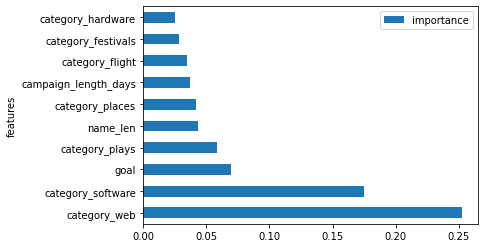

In [34]:
# Feature importance graph
feat_importances_basic = pd.DataFrame(data=X_basic.columns, columns=['features'])
feat_importances_basic['importance'] = xgb_model_loaded.feature_importances_
feat_importances_basic.sort_values('importance', ascending=False, inplace=True)
top_10_basic = feat_importances_basic.head(10)

top_10_basic.plot(kind='barh', x='features', y='importance');

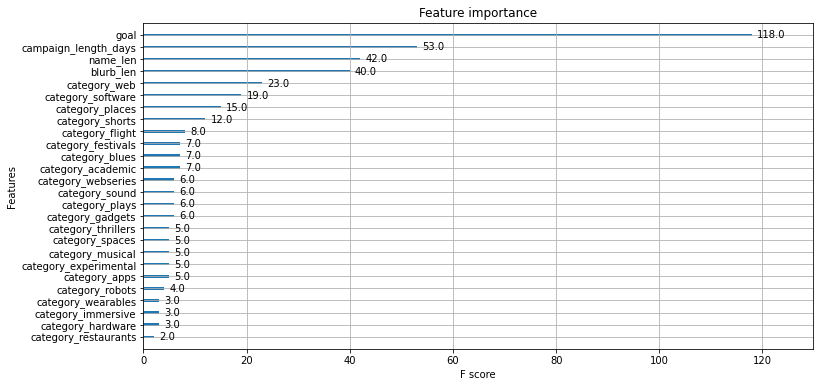

In [35]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
xgboost.plot_importance(xgb_model_loaded, ax=ax);

In [42]:
# explainer = shap.TreeExplainer(xgb_model_loaded)
# shap_values = explainer.shap_values(X_basic)

In [43]:
# shap.initJs()

In [44]:
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_basic.iloc[:100,:])